In [1]:
import os
import torch
import torch.nn as nn
from PIL import Image
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split

In [20]:
import os
from PIL import Image
from torch.utils.data import Dataset
import random

class AugmentedDataset(Dataset):
    def __init__(self, directory, transform_0, transform_1, target_count=28000):
        self.directory = directory
        self.transform_0 = transform_0
        self.transform_1 = transform_1
        self.target_count = target_count
        self.data = []
        self.labels = []

        for label in [0, 1]:
            label_dir = f"{directory}/{label}"
            for img_path in os.listdir(label_dir):
                self.data.append(f"{label_dir}/{img_path}")
                self.labels.append(label)
        
        self.balance_data()

    def balance_data(self):
        data_0 = [self.data[i] for i in range(len(self.labels)) if self.labels[i] == 0]
        data_1 = [self.data[i] for i in range(len(self.labels)) if self.labels[i] == 1]

        if len(data_0) > self.target_count:
            data_0 = random.sample(data_0, self.target_count)
        else:
            while len(data_0) < self.target_count:
                data_0.append(random.choice(data_0))
        
        if len(data_1) > self.target_count:
            data_1 = random.sample(data_1, self.target_count)
        else:
            while len(data_1) < self.target_count:
                data_1.append(random.choice(data_1))
        
        self.data = data_0 + data_1
        self.labels = [0] * len(data_0) + [1] * len(data_1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert('RGB')

        if label == 0:
            img = self.transform_0(img)
        else:
            img = self.transform_1(img)

        return img, label

In [51]:
DATA_DIR = "../input/soccernet-classifier/ds"
BATCH_SIZE = 32
IMG_SIZE = 64
TRAIN_RATIO = 0.05

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  # Random crop, resized to 64x64
    transforms.Resize((64, 64)),  # Ensure final image size is 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize based on your data's stats
])

dataset = AugmentedDataset(directory=DATA_DIR, transform_0=transform, transform_1=transform)

train_size = int(TRAIN_RATIO * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

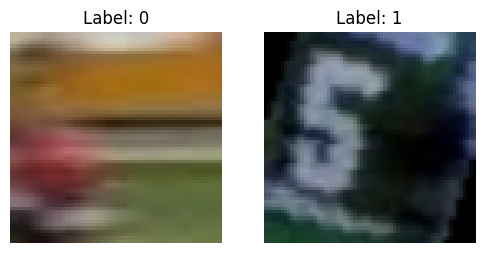

In [56]:
label_0_img, label_1_img = None, None

for images, labels in train_loader:
    for img, label in zip(images, labels):
        if label.item() == 0 and label_0_img is None:
            label_0_img = img
        elif label.item() == 1 and label_1_img is None:
            label_1_img = img
        if label_0_img is not None and label_1_img is not None:
            break
    if label_0_img is not None and label_1_img is not None:
        break

def unnormalize(tensor):
    return (tensor * 0.5) + 0.5

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(unnormalize(label_0_img).permute(1, 2, 0).numpy()) 
axes[0].set_title("Label: 0")
axes[0].axis("off")

axes[1].imshow(unnormalize(label_1_img).permute(1, 2, 0).numpy())
axes[1].set_title("Label: 1")
axes[1].axis("off")

plt.show()

In [57]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Linear(256, 64),  
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BinaryClassifier().to(device)
print(device)

cuda


In [59]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [60]:
from tqdm.notebook import tqdm

def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.float().to(device)
            
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

In [61]:
train_model(model, train_loader, criterion, optimizer, epochs=10)

Epoch 1/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.2913


Epoch 2/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.0855


Epoch 3/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.0764


Epoch 4/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0476


Epoch 5/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0480


Epoch 6/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0320


Epoch 7/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0256


Epoch 8/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0192


Epoch 9/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0232


Epoch 10/10:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0215


In [62]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
        
            predictions = (outputs >= 0.5).long()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    accuracy = (correct / total) * 100
    return accuracy

In [63]:
print(f"Test set accuracy {evaluate_model(model, test_loader)} %")
print(f"Train set accuracy {evaluate_model(model, train_loader)} %")

  0%|          | 0/1663 [00:00<?, ?it/s]

Test set accuracy 98.3139097744361 %


  0%|          | 0/88 [00:00<?, ?it/s]

Train set accuracy 99.03571428571428 %


In [50]:
torch.save(model.state_dict(), "model_weights_1090.pth")